In [28]:
import sys
import pandas as pd
from pycaret.classification import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

## Peak quality classification

### Introduction

In this document, peak classifiers are trained  on data from: 
* FAME salivary metabolomics analysis
* ENVIRONAGE urinary metabolomics analysis
* FGFP fecal metabolomics
* FGFP fecal lipidomics
  
The models are evaluated on a hold-out test set of themselves (70% to train and 30% to validate)

Both multi-class (Bad, Ambiguous and Good) as binary (Bad, Good) classifiers were evaluated. To create the binary datasets, all Ambiguous peaks were labeled as Bad.

For lipidomics, a single matrix model was not considered due to the small and imbalanced size of the data. 

Finally, a mixed-matrix model was trained on FAME, ENVIRONAGE and FGFP lipidomics. FGFP metabolomics was left out as validation dataset.

### Data loading

Data is loaded and inspected.

In the multi-class setting, to allow fair comparison between the models, the datasets were subsampled so that each contains 100 Bad, 46 Ambiguous and 100 Good peaks. 

In the binary setting,datasets were subsampled so that each dataset was balanced with 130 bad peaks and 130 good peaks. 

#### FGFP - metabolomics


In [162]:
# Load data
data_fgfp_met = pd.read_csv("C:/Users/pvgeende/OneDrive - UGent/Documents/publications/tardis_paper/data/quality_analysis/metabo_fgfp_labeled.csv")
# Select columns
data_fgfp_met = data_fgfp_met[["AUC","SNR","peak_cor","pop","Rating"]]
# Set levels for factor
quality_levels = pd.Series([
  "Bad", "Ambiguous", "Good"
])
data_fgfp_met["Rating"] = pd.Categorical(data_fgfp_met["Rating"], categories=quality_levels)
data_fgfp_met["Rating"].value_counts().sort_index()

Bad          125
Ambiguous    110
Good         130
Name: Rating, dtype: int64

In [163]:
# Subsample
bad_rows = data_fgfp_met[data_fgfp_met['Rating'] == 'Bad']
amb_rows = data_fgfp_met[data_fgfp_met['Rating'] == 'Ambiguous']
good_rows = data_fgfp_met[data_fgfp_met['Rating'] == 'Good']

# Sample the required number of rows
bad_sample = bad_rows.sample(n=100, random_state=42)
amb_sample = amb_rows.sample(n=46, random_state=42)
good_sample = good_rows.sample(n=100, random_state=42)

# Combine the subsamples into a single DataFrame
fgfp_met_sub = pd.concat([bad_sample, amb_sample, good_sample])

fgfp_met_sub["Rating"].value_counts().sort_index()

Bad          100
Ambiguous     46
Good         100
Name: Rating, dtype: int64

In [164]:
bad_rows = data_fgfp_met[data_fgfp_met['Rating'] == 'Bad']
amb_rows = data_fgfp_met[data_fgfp_met['Rating'] == 'Ambiguous']
good_rows = data_fgfp_met[data_fgfp_met['Rating'] == 'Good']

# Sample the required number of rows
bad_sample = bad_rows.sample(n=100, random_state=42)
amb_sample = amb_rows.sample(n=100, random_state=42)
good_sample = good_rows.sample(n=100, random_state=42)

# Combine the subsamples into a single DataFrame
fgfp_met_sub_2 = pd.concat([bad_sample, amb_sample, good_sample])

fgfp_met_sub_2["Rating"].value_counts().sort_index()

Bad          100
Ambiguous    100
Good         100
Name: Rating, dtype: int64

In [165]:
# Make a copy for binary classification
data_fgfp_met_bin = data_fgfp_met.copy()
data_fgfp_met_bin['Rating'] = data_fgfp_met_bin['Rating'].replace('Ambiguous', 'Bad')
data_fgfp_met_bin["Rating"].value_counts().sort_index()

Bad     235
Good    130
Name: Rating, dtype: int64

In [166]:
data_fgfp_met_bin_2 = data_fgfp_met_bin.copy()

In [167]:
# subsample 
bad_rows = data_fgfp_met_bin[data_fgfp_met_bin['Rating'] == 'Bad']
good_rows = data_fgfp_met_bin[data_fgfp_met_bin['Rating'] == 'Good']

# Sample the required number of rows
bad_sample = bad_rows.sample(n=130, random_state=42)
good_sample = good_rows.sample(n=130, random_state=42)

# Combine the subsamples into a single DataFrame
data_fgfp_met_bin = pd.concat([bad_sample, good_sample])

In [168]:
data_fgfp_met_bin["Rating"].value_counts().sort_index()

Bad     130
Good    130
Name: Rating, dtype: int64

#### ENVIRONAGE

In [130]:
data_env = pd.read_csv("C:/Users/pvgeende/OneDrive - UGent/Documents/publications/tardis_paper/data/quality_analysis/environage_labeled.csv")
data_env = data_env[["AUC","SNR","peak_cor","pop","Rating"]]
data_env["Rating"] = pd.Categorical(data_env["Rating"], categories=quality_levels)
data_env["Rating"].value_counts().sort_index()

Bad          121
Ambiguous     50
Good         187
Name: Rating, dtype: int64

In [131]:
# Subsample
bad_rows = data_env[data_env['Rating'] == 'Bad']
amb_rows = data_env[data_env['Rating'] == 'Ambiguous']
good_rows = data_env[data_env['Rating'] == 'Good']

# Sample the required number of rows
bad_sample = bad_rows.sample(n=100, random_state=42)
amb_sample = amb_rows.sample(n=46, random_state=42)
good_sample = good_rows.sample(n=100, random_state=42)

# Combine the subsamples into a single DataFrame
env_sub = pd.concat([bad_sample, amb_sample, good_sample])

env_sub["Rating"].value_counts().sort_index()

Bad          100
Ambiguous     46
Good         100
Name: Rating, dtype: int64

In [132]:
data_env_binary = data_env.copy()
data_env_binary['Rating'] = data_env_binary['Rating'].replace('Ambiguous', 'Bad')
data_env_binary["Rating"].value_counts().sort_index()

Bad     171
Good    187
Name: Rating, dtype: int64

In [133]:
bad_rows = data_env_binary[data_env_binary['Rating'] == 'Bad']
good_rows = data_env_binary[data_env_binary['Rating'] == 'Good']
bad_sample = bad_rows.sample(n=130, random_state=42)
good_sample = good_rows.sample(n=130, random_state=42)
data_env_binary = pd.concat([bad_sample, good_sample])

In [134]:
data_env_binary["Rating"].value_counts().sort_index()

Bad     130
Good    130
Name: Rating, dtype: int64

#### FAME

In [172]:
data_fame = pd.read_csv("C:/Users/pvgeende/OneDrive - UGent/Documents/publications/tardis_paper/data/quality_analysis/fame_feat_labeled.csv")
data_fame = data_fame[["AUC","SNR","peak_cor","pop","Rating"]]
data_fame["Rating"] = pd.Categorical(data_fame["Rating"], categories=quality_levels)
data_fame["Rating"].value_counts().sort_index()

Bad          110
Ambiguous     46
Good         163
Name: Rating, dtype: int64

In [173]:
# Subsample
bad_rows = data_fame[data_fame['Rating'] == 'Bad']
amb_rows = data_fame[data_fame['Rating'] == 'Ambiguous']
good_rows = data_fame[data_fame['Rating'] == 'Good']

# Sample the required number of rows
bad_sample = bad_rows.sample(n=100, random_state=42)
amb_sample = amb_rows.sample(n=46, random_state=42)
good_sample = good_rows.sample(n=100, random_state=42)

# Combine the subsamples into a single DataFrame
fame_sub = pd.concat([bad_sample, amb_sample, good_sample])

fame_sub["Rating"].value_counts().sort_index()

Bad          100
Ambiguous     46
Good         100
Name: Rating, dtype: int64

In [174]:
data_fame_binary = data_fame.copy()
data_fame_binary['Rating'] = data_fame_binary['Rating'].replace('Ambiguous', 'Bad')
data_fame_binary["Rating"].value_counts().sort_index()

Bad     156
Good    163
Name: Rating, dtype: int64

In [175]:
bad_rows = data_fame_binary[data_fame_binary['Rating'] == 'Bad']
good_rows = data_fame_binary[data_fame_binary['Rating'] == 'Good']
bad_sample = bad_rows.sample(n=130, random_state=42)
good_sample = good_rows.sample(n=130, random_state=42)
data_fame_binary = pd.concat([bad_sample, good_sample])

In [176]:
data_fame_binary["Rating"].value_counts().sort_index()

Bad     130
Good    130
Name: Rating, dtype: int64

#### Mixed dataset

In [140]:
lip = pd.read_csv("C:/Users/pvgeende/OneDrive - UGent/Documents/publications/tardis_paper/data/quality_analysis/fgfp_lipids_labeled.csv")
lip = lip[["AUC","SNR","peak_cor","pop","Rating"]]
lip["Rating"] = pd.Categorical(lip["Rating"], categories=quality_levels)
lip["Rating"].value_counts().sort_index()

Bad          55
Ambiguous    17
Good         38
Name: Rating, dtype: int64

In [141]:
mixed_set = pd.concat([data_fame,data_env,lip],ignore_index=True)

In [142]:
mixed_set["Rating"] = pd.Categorical(mixed_set["Rating"], categories=quality_levels)
mixed_set["Rating"].value_counts().sort_index()

Bad          286
Ambiguous    113
Good         388
Name: Rating, dtype: int64

In [143]:
mixed_set_binary = mixed_set.copy()
mixed_set_binary['Rating'] = mixed_set_binary['Rating'].replace('Ambiguous', 'Bad')
mixed_set_binary["Rating"].value_counts().sort_index()

Bad     399
Good    388
Name: Rating, dtype: int64

### Single matrix models

#### FAME 

In [144]:
s_fame =  setup(fame_sub, target = 'Rating', session_id = 123,train_size = 0.7)
rf_fame = create_model("rf")
tuned_rf_fame = tune_model(rf_fame,n_iter=100)
test_fame = get_config(variable="X_test")
test_y_fame = get_config(variable="y_test")
predictions_fame = predict_model(tuned_rf_fame, data = test_fame)


,Description,Value
0,Session id,123
1,Target,Rating
2,Target type,Multiclass
3,Target mapping,"Ambiguous: 0, Bad: 1, Good: 2"
4,Original data shape,"(246, 5)"
5,Transformed data shape,"(246, 5)"
6,Transformed train set shape,"(172, 5)"
7,Transformed test set shape,"(74, 5)"
8,Numeric features,4
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,0.9361,0.8333,0.8650,0.7921,0.7313,0.7603
1,0.7778,0.8903,0.7778,0.7907,0.7806,0.6620,0.6651
2,0.6471,0.9319,0.6471,0.6471,0.6471,0.4396,0.4396
3,0.8235,0.9084,0.8235,0.8015,0.8078,0.7135,0.7178
4,0.8235,0.8643,0.8235,0.8015,0.8078,0.7135,0.7178
5,0.7647,0.9265,0.7647,0.8088,0.7734,0.6344,0.6448
6,0.9412,0.9861,0.9412,0.9485,0.9373,0.9045,0.9100
7,0.5882,0.9164,0.5882,0.7614,0.5825,0.3866,0.4289
8,0.8824,0.9088,0.8824,0.9085,0.8603,0.8046,0.8256


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8889,0.9701,0.8889,0.9028,0.8741,0.8235,0.8367
1,0.7222,0.8907,0.7222,0.8082,0.7444,0.5890,0.6085
2,0.7647,0.9429,0.7647,0.8255,0.7851,0.6421,0.6526
3,0.8824,0.8983,0.8824,0.8824,0.8824,0.8132,0.8132
4,0.8235,0.8899,0.8235,0.8015,0.8078,0.7135,0.7178
5,0.8235,0.8924,0.8235,0.8706,0.8284,0.7316,0.7475
6,0.9412,0.9899,0.9412,0.9559,0.9431,0.9086,0.9136
7,0.7647,0.9378,0.7647,0.7908,0.7623,0.6264,0.6406
8,0.8824,0.9202,0.8824,0.9085,0.8603,0.8046,0.8256


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


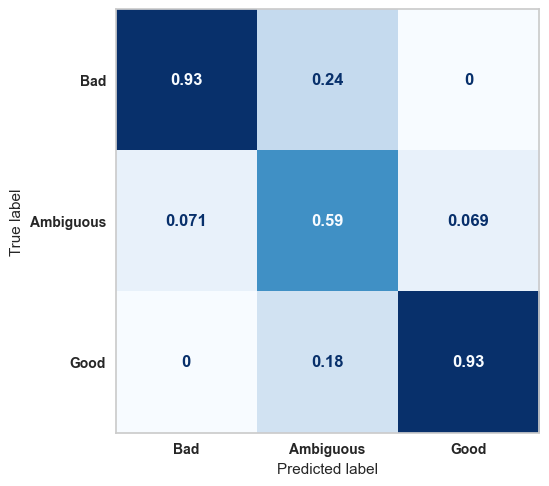

In [145]:
font = {'family' : 'arial',
    'weight' : 'bold',
    'size'   : 12}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay.from_predictions(test_y_fame, predictions_fame["prediction_label"],colorbar = False,cmap=plt.cm.Blues, labels = ["Bad","Ambiguous","Good"],normalize = "pred")
#plt.xticks(fontsize = 6)
#plt.yticks(fontsize = 6)
#plt.rc('axes', titlesize=6)
plt.grid(b=None)
#plt.gcf().set_size_inches(1.66, 1.66)
plt.savefig("fame_multiclass.png", dpi=300)

#### FAME - binary

In [160]:
s_fame_binary = setup(data_fame_binary, target = 'Rating', session_id = 123,train_size = 0.7)
rf_fame_binary = create_model("rf")
tuned_rf_fame_bin = tune_model(rf_fame_binary,n_iter=100)
test_fame_bin = get_config(variable="X_test")
test_y_fame_bin = get_config(variable="y_test")
predictions_fame_bin = predict_model(tuned_rf_fame_bin, data = test_fame_bin)


,Description,Value
0,Session id,123
1,Target,Rating
2,Target type,Binary
3,Target mapping,"Bad: 0, Good: 1"
4,Original data shape,"(260, 5)"
5,Transformed data shape,"(260, 5)"
6,Transformed train set shape,"(182, 5)"
7,Transformed test set shape,"(78, 5)"
8,Numeric features,4
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9474,1.0000,0.9474,0.9522,0.9471,0.8939,0.8989
1,0.8947,0.9778,0.8947,0.8947,0.8947,0.7889,0.7889
2,0.9444,1.0000,0.9444,0.9500,0.9443,0.8889,0.8944
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.7778,0.8889,0.7778,0.7922,0.7750,0.5556,0.5698
5,0.8889,0.9877,0.8889,0.9091,0.8875,0.7778,0.7977
6,0.9444,1.0000,0.9444,0.9500,0.9443,0.8889,0.8944
7,0.7778,0.9136,0.7778,0.7922,0.7750,0.5556,0.5698
8,0.9444,0.9877,0.9444,0.9500,0.9443,0.8889,0.8944


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9474,0.9778,0.9474,0.9526,0.9474,0.8950,0.9000
2,0.9444,0.9877,0.9444,0.9500,0.9443,0.8889,0.8944
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8333,0.8889,0.8333,0.8750,0.8286,0.6667,0.7071
5,0.9444,1.0000,0.9444,0.9500,0.9443,0.8889,0.8944
6,0.9444,1.0000,0.9444,0.9500,0.9443,0.8889,0.8944
7,0.7778,0.9259,0.7778,0.7922,0.7750,0.5556,0.5698
8,0.8889,0.9753,0.8889,0.9091,0.8875,0.7778,0.7977


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


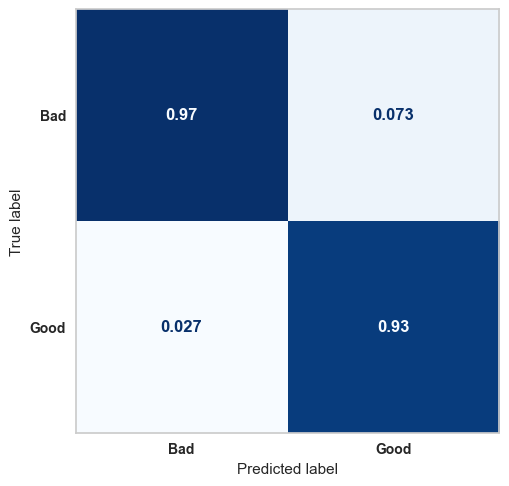

In [161]:
font = {'family' : 'arial','weight' : 'bold','size'   : 12}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay.from_predictions(test_y_fame_bin, predictions_fame_bin["prediction_label"],colorbar = False,cmap=plt.cm.Blues, labels = ["Bad","Good"],normalize = "pred")
#plt.xticks(fontsize = 6)
#plt.yticks(fontsize = 6)
#plt.rc('axes', titlesize=6)
plt.grid(b=None)
#plt.gcf().set_size_inches(1.66, 1.66)
plt.savefig("fame_binary.png", dpi=300)

#### ENVIRONAGE

In [148]:
# setup pycaret environment
s_env =  setup(env_sub, target = 'Rating', session_id = 123,train_size = 0.7)
# create rf classifier
rf_env = create_model("rf")
# tune parameters using accuracy as target
tuned_rf_env = tune_model(rf_env,n_iter=100)
# extract test X and Y data and make predictions on hold-out test to create confusion matrix
test_env = get_config(variable="X_test")
test_y_env = get_config(variable="y_test")
predictions_env = predict_model(tuned_rf_env, data = test_env)


,Description,Value
0,Session id,123
1,Target,Rating
2,Target type,Multiclass
3,Target mapping,"Ambiguous: 0, Bad: 1, Good: 2"
4,Original data shape,"(246, 5)"
5,Transformed data shape,"(246, 5)"
6,Transformed train set shape,"(172, 5)"
7,Transformed test set shape,"(74, 5)"
8,Numeric features,4
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5556,0.8386,0.5556,0.5494,0.5394,0.2941,0.3004
1,0.5000,0.7908,0.5000,0.5049,0.4931,0.2286,0.2331
2,0.8235,0.9134,0.8235,0.8203,0.8110,0.7135,0.7263
3,0.8235,0.9181,0.8235,0.8497,0.8015,0.7069,0.7253
4,0.7647,0.9504,0.7647,0.7673,0.7525,0.6264,0.6406
5,0.5882,0.8118,0.5882,0.5490,0.5622,0.3315,0.3374
6,0.7647,0.8790,0.7647,0.7426,0.7490,0.6180,0.6217
7,0.8824,0.8929,0.8824,0.8897,0.8821,0.8132,0.8177
8,0.7059,0.7857,0.7059,0.7451,0.7108,0.5330,0.5451


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6111,0.8445,0.6111,0.6134,0.6097,0.4000,0.4019
1,0.6111,0.7987,0.6111,0.6222,0.6056,0.4167,0.4245
2,0.8235,0.8933,0.8235,0.8203,0.8110,0.7135,0.7263
3,0.9412,0.9529,0.9412,0.9485,0.9409,0.9066,0.9116
4,0.8235,0.9345,0.8235,0.8779,0.8161,0.7316,0.7596
5,0.5882,0.8319,0.5882,0.7020,0.6305,0.3866,0.4012
6,0.8235,0.9403,0.8235,0.8211,0.8187,0.7198,0.7238
7,0.7647,0.8958,0.7647,0.7794,0.7683,0.6264,0.6298
8,0.7059,0.8336,0.7059,0.7451,0.7108,0.5330,0.5451


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


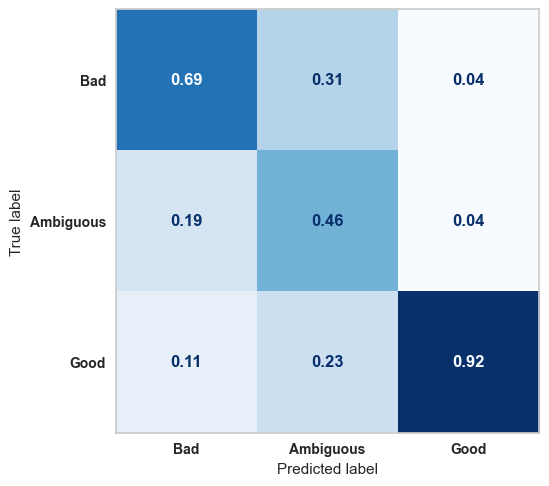

In [149]:
font = {'family' : 'arial','weight' : 'bold','size'   : 12}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay.from_predictions(test_y_env, predictions_env["prediction_label"],colorbar = False,cmap=plt.cm.Blues, labels = ["Bad","Ambiguous","Good"],normalize = "pred")
#plt.xticks(fontsize = 6)
#plt.yticks(fontsize = 6)
#plt.rc('axes', titlesize=6)
plt.grid(b=None)
#plt.gcf().set_size_inches(1.66, 1.66)
plt.savefig("env_multiclass.png", dpi=300)

#### ENVIRONAGE - binary

In [150]:
# setup pycaret environment
s_binary = setup(data_env_binary, target = 'Rating', session_id = 123,train_size = 0.7)
#  create rf classifier
rf_env_bin = create_model("rf")
# tune parameters using accuracy as target
tuned_rf_env_bin = tune_model(rf_env_bin,n_iter=100)
# extract test X and Y data and make predictions on hold-out test to create confusion matrix
test_env_bin = get_config(variable="X_test")
test_y_env_bin = get_config(variable="y_test")
predictions_env_bin = predict_model(tuned_rf_env_bin, data = test_env_bin)


,Description,Value
0,Session id,123
1,Target,Rating
2,Target type,Binary
3,Target mapping,"Bad: 0, Good: 1"
4,Original data shape,"(260, 5)"
5,Transformed data shape,"(260, 5)"
6,Transformed train set shape,"(182, 5)"
7,Transformed test set shape,"(78, 5)"
8,Numeric features,4
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7895,0.8667,0.7895,0.7895,0.7895,0.5778,0.5778
1,0.6842,0.7389,0.6842,0.6962,0.6825,0.3736,0.3820
2,0.7778,0.8519,0.7778,0.7922,0.7750,0.5556,0.5698
3,0.8333,0.9753,0.8333,0.8375,0.8328,0.6667,0.6708
4,0.7222,0.9259,0.7222,0.8214,0.6990,0.4444,0.5345
5,0.8333,0.9753,0.8333,0.8375,0.8328,0.6667,0.6708
6,0.9444,0.9753,0.9444,0.9500,0.9443,0.8889,0.8944
7,0.9444,0.9630,0.9444,0.9500,0.9443,0.8889,0.8944
8,0.6111,0.8086,0.6111,0.6125,0.6099,0.2222,0.2236


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7895,0.8222,0.7895,0.8050,0.7883,0.5824,0.5955
1,0.7895,0.8222,0.7895,0.8543,0.7823,0.5870,0.6445
2,0.7778,0.8457,0.7778,0.7922,0.7750,0.5556,0.5698
3,0.9444,1.0000,0.9444,0.9500,0.9443,0.8889,0.8944
4,0.6667,0.9136,0.6667,0.8000,0.6250,0.3333,0.4472
5,0.8333,0.9259,0.8333,0.8375,0.8328,0.6667,0.6708
6,0.9444,0.9568,0.9444,0.9500,0.9443,0.8889,0.8944
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.6667,0.7778,0.6667,0.6667,0.6667,0.3333,0.3333


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


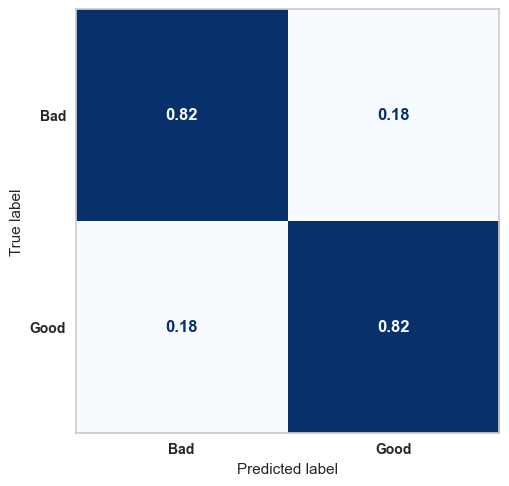

In [151]:
font = {'family' : 'arial','weight' : 'bold','size'   : 12}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay.from_predictions(test_y_env_bin, predictions_env_bin["prediction_label"],colorbar = False,cmap=plt.cm.Blues, labels = ["Bad","Good"],normalize = "pred")
#plt.xticks(fontsize = 6)
#plt.yticks(fontsize = 6)
#plt.rc('axes', titlesize=6)
plt.grid(b=None)
#plt.gcf().set_size_inches(1.66, 1.66)
plt.savefig("env_binary.png", dpi=300)

#### FGFP - metabolomics

In [152]:
s_fgfp_met =  setup(fgfp_met_sub, target = 'Rating', session_id = 123,train_size = 0.7)
rf_fgfp_met = create_model("rf")
tuned_rf_fgfp_met = tune_model(rf_fgfp_met,n_iter=100)
test_fgfp_met = get_config(variable="X_test")
test_y_fgfp_met = get_config(variable="y_test")
predictions_fgfp_met = predict_model(tuned_rf_fgfp_met, data = test_fgfp_met)


,Description,Value
0,Session id,123
1,Target,Rating
2,Target type,Multiclass
3,Target mapping,"Ambiguous: 0, Bad: 1, Good: 2"
4,Original data shape,"(246, 5)"
5,Transformed data shape,"(246, 5)"
6,Transformed train set shape,"(172, 5)"
7,Transformed test set shape,"(74, 5)"
8,Numeric features,4
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7222,0.9203,0.7222,0.5617,0.6319,0.5455,0.5855
1,0.8333,0.9201,0.8333,0.8650,0.7921,0.7313,0.7603
2,0.7647,0.9412,0.7647,0.7516,0.7476,0.6180,0.6291
3,0.7059,0.8685,0.7059,0.8305,0.7221,0.5707,0.6109
4,0.8235,0.9916,0.8235,0.7000,0.7509,0.7000,0.7455
5,0.6471,0.9324,0.6471,0.7673,0.6515,0.4632,0.4945
6,0.8824,0.9353,0.8824,0.8897,0.8784,0.8090,0.8139
7,0.7059,0.8450,0.7059,0.6618,0.6824,0.5225,0.5256
8,0.7059,0.8282,0.7059,0.6863,0.6889,0.5225,0.5319


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.9206,0.7778,0.7431,0.7481,0.6471,0.6574
1,0.7222,0.9491,0.7222,0.7006,0.7029,0.5652,0.5738
2,0.8235,0.9412,0.8235,0.8211,0.8187,0.7198,0.7238
3,0.7059,0.8706,0.7059,0.7941,0.7112,0.5619,0.5893
4,0.9412,0.9958,0.9412,0.9559,0.9431,0.9086,0.9136
5,0.7059,0.9504,0.7059,0.8309,0.7098,0.5619,0.6022
6,0.8235,0.9588,0.8235,0.8088,0.8118,0.7135,0.7178
7,0.7647,0.8676,0.7647,0.7647,0.7647,0.6264,0.6264
8,0.7647,0.8210,0.7647,0.6863,0.7206,0.6092,0.6251


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


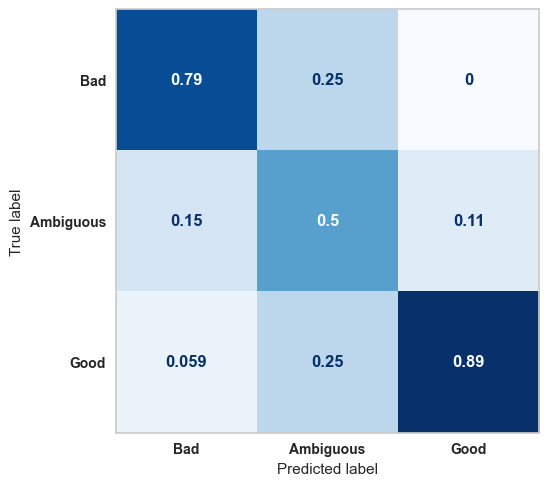

In [153]:
font = {'family' : 'arial',
    'weight' : 'bold',
    'size'   : 12}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay.from_predictions(test_y_fgfp_met, predictions_fgfp_met["prediction_label"],colorbar = False,cmap=plt.cm.Blues, labels = ["Bad","Ambiguous","Good"],normalize = "pred")
#plt.xticks(fontsize = 6)
#plt.yticks(fontsize = 6)
#plt.rc('axes', titlesize=6)
plt.grid(b=None)
#plt.gcf().set_size_inches(1.66, 1.66)
plt.savefig("fgfp_multi.png", dpi=300)

#### FGFP - metabolomics - balanced

In [154]:
s_fgfp_met =  setup(fgfp_met_sub_2, target = 'Rating', session_id = 123,train_size = 0.7)
rf_fgfp_met = create_model("rf")
tuned_rf_fgfp_met = tune_model(rf_fgfp_met,n_iter=100)
test_fgfp_met = get_config(variable="X_test")
test_y_fgfp_met = get_config(variable="y_test")
predictions_fgfp_met = predict_model(tuned_rf_fgfp_met, data = test_fgfp_met)


,Description,Value
0,Session id,123
1,Target,Rating
2,Target type,Multiclass
3,Target mapping,"Ambiguous: 0, Bad: 1, Good: 2"
4,Original data shape,"(300, 5)"
5,Transformed data shape,"(300, 5)"
6,Transformed train set shape,"(210, 5)"
7,Transformed test set shape,"(90, 5)"
8,Numeric features,4
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7619,0.9303,0.7619,0.8259,0.7143,0.6429,0.6889
1,0.8095,0.9507,0.8095,0.8083,0.8000,0.7143,0.7217
2,0.8095,0.9558,0.8095,0.8083,0.8000,0.7143,0.7217
3,0.7619,0.8980,0.7619,0.8111,0.7695,0.6429,0.6587
4,0.8571,0.9218,0.8571,0.8611,0.8564,0.7857,0.7884
5,0.6190,0.8912,0.6190,0.6190,0.6190,0.4286,0.4286
6,0.6667,0.8367,0.6667,0.7083,0.6778,0.5000,0.5052
7,0.5714,0.8435,0.5714,0.5853,0.5766,0.3571,0.3584
8,0.6667,0.8980,0.6667,0.6667,0.6603,0.5000,0.5052


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8095,0.8878,0.8095,0.8116,0.7996,0.7143,0.7242
1,0.8571,0.9490,0.8571,0.8552,0.8532,0.7857,0.7884
2,0.9048,0.9626,0.9048,0.9048,0.9048,0.8571,0.8571
3,0.7143,0.9082,0.7143,0.7566,0.7242,0.5714,0.5794
4,0.9048,0.9320,0.9048,0.9048,0.9048,0.8571,0.8571
5,0.7143,0.9116,0.7143,0.7183,0.7136,0.5714,0.5734
6,0.6667,0.8197,0.6667,0.7083,0.6778,0.5000,0.5052
7,0.6190,0.7993,0.6190,0.6190,0.6190,0.4286,0.4286
8,0.7143,0.8741,0.7143,0.7183,0.7136,0.5714,0.5734


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


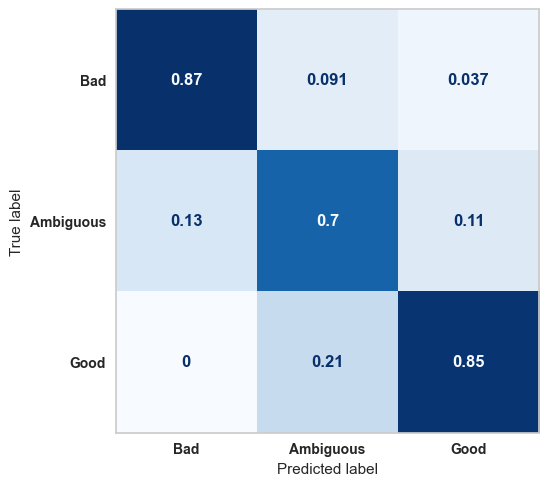

In [155]:
font = {'family' : 'arial',
    'weight' : 'bold',
    'size'   : 12}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay.from_predictions(test_y_fgfp_met, predictions_fgfp_met["prediction_label"],colorbar = False,cmap=plt.cm.Blues, labels = ["Bad","Ambiguous","Good"],normalize = "pred")
#plt.xticks(fontsize = 6)
#plt.yticks(fontsize = 6)
#plt.rc('axes', titlesize=6)
plt.grid(b=None)
#plt.gcf().set_size_inches(1.66, 1.66)
plt.savefig("fgfp_multi_balanced.png", dpi=300)

#### FGFP - metabolomics - binary

In [158]:
s_fgfp_met_bin =  setup(data_fgfp_met_bin, target = 'Rating', session_id = 123,train_size = 0.7)
rf_fgfp_met_bin = create_model("rf")
tuned_rf_fgfp_met_bin = tune_model(rf_fgfp_met_bin,n_iter=100)
test_fgfp_met_bin = get_config(variable="X_test")
test_y_fgfp_met_bin = get_config(variable="y_test")
predictions_fgfp_met_bin = predict_model(tuned_rf_fgfp_met_bin, data = test_fgfp_met_bin)


,Description,Value
0,Session id,123
1,Target,Rating
2,Target type,Binary
3,Target mapping,"Bad: 0, Good: 1"
4,Original data shape,"(260, 5)"
5,Transformed data shape,"(260, 5)"
6,Transformed train set shape,"(182, 5)"
7,Transformed test set shape,"(78, 5)"
8,Numeric features,4
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9474,0.9389,0.9474,0.9526,0.9474,0.8950,0.9000
1,0.8947,0.9444,0.8947,0.8947,0.8947,0.7889,0.7889
2,0.8333,0.9136,0.8333,0.8375,0.8328,0.6667,0.6708
3,0.7778,0.9198,0.7778,0.7922,0.7750,0.5556,0.5698
4,0.8333,0.8642,0.8333,0.8375,0.8328,0.6667,0.6708
5,0.9444,0.9383,0.9444,0.9500,0.9443,0.8889,0.8944
6,0.9444,0.9877,0.9444,0.9500,0.9443,0.8889,0.8944
7,0.8889,0.9383,0.8889,0.8889,0.8889,0.7778,0.7778
8,0.6667,0.7469,0.6667,0.6667,0.6667,0.3333,0.3333


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9474,0.9556,0.9474,0.9526,0.9474,0.8950,0.9000
1,0.8947,0.9222,0.8947,0.8947,0.8947,0.7889,0.7889
2,0.8333,0.8642,0.8333,0.8375,0.8328,0.6667,0.6708
3,0.7778,0.8889,0.7778,0.7922,0.7750,0.5556,0.5698
4,0.8333,0.8642,0.8333,0.8375,0.8328,0.6667,0.6708
5,0.8889,0.9259,0.8889,0.8889,0.8889,0.7778,0.7778
6,0.9444,1.0000,0.9444,0.9500,0.9443,0.8889,0.8944
7,0.9444,0.9259,0.9444,0.9500,0.9443,0.8889,0.8944
8,0.7222,0.8025,0.7222,0.7250,0.7214,0.4444,0.4472


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


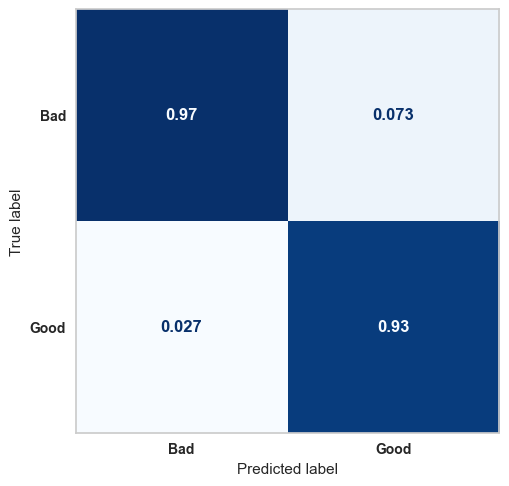

In [179]:
font = {'family' : 'arial',
    'weight' : 'bold',
    'size'   : 12}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay.from_predictions(test_y_fgfp_met_bin, predictions_fgfp_met_bin["prediction_label"],colorbar = False,cmap=plt.cm.Blues, labels = ["Bad","Good"],normalize = "pred")
#plt.xticks(fontsize = 6)
#plt.yticks(fontsize = 6)
#plt.rc('axes', titlesize=6)
plt.grid(b=None)
#plt.gcf().set_size_inches(1.66, 1.66)
plt.savefig("fgfp_binary.png", dpi=300)

In [182]:
test_y_fgfp_met_bin

147     Bad
169    Good
28     Good
308    Good
35     Good
       ... 
315    Good
238     Bad
245     Bad
228     Bad
137    Good
Name: Rating, Length: 78, dtype: category
Categories (2, object): ['Bad', 'Good']

In [185]:
test_y_fame_bin

83      Bad
124    Good
9      Good
151    Good
203    Good
       ... 
173    Good
103     Bad
118     Bad
87      Bad
245    Good
Name: Rating, Length: 78, dtype: category
Categories (2, object): ['Bad', 'Good']

### Multi-matrix model

#### Binary

,Description,Value
0,Session id,123
1,Target,Rating
2,Target type,Binary
3,Target mapping,"Bad: 0, Good: 1"
4,Original data shape,"(1152, 5)"
5,Transformed data shape,"(1152, 5)"
6,Transformed train set shape,"(787, 5)"
7,Transformed test set shape,"(365, 5)"
8,Numeric features,4
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8608,0.9465,0.8608,0.8630,0.8606,0.7217,0.7238
1,0.9367,0.9699,0.9367,0.9439,0.9365,0.8736,0.8807
2,0.9241,0.9846,0.9241,0.9285,0.9239,0.8483,0.8526
3,0.9114,0.9821,0.9114,0.9137,0.9112,0.8226,0.8250
4,0.8481,0.9561,0.8481,0.8561,0.8471,0.6956,0.7038
5,0.8101,0.9151,0.8101,0.8155,0.8095,0.6208,0.6258
6,0.8354,0.9292,0.8354,0.8467,0.8343,0.6716,0.6823
7,0.7564,0.8708,0.7564,0.7649,0.7544,0.5128,0.5213
8,0.7949,0.8993,0.7949,0.8145,0.7907,0.5868,0.6074


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9241,0.9590,0.9241,0.9342,0.9237,0.8484,0.8583
1,0.9241,0.9859,0.9241,0.9342,0.9237,0.8484,0.8583
2,0.9114,0.9821,0.9114,0.9182,0.9111,0.8230,0.8297
3,0.9114,0.9814,0.9114,0.9137,0.9112,0.8226,0.8250
4,0.8734,0.9429,0.8734,0.8771,0.8730,0.7465,0.7503
5,0.8228,0.9417,0.8228,0.8264,0.8224,0.6460,0.6493
6,0.8481,0.9353,0.8481,0.8566,0.8474,0.6967,0.7049
7,0.7949,0.9080,0.7949,0.8020,0.7937,0.5897,0.5968
8,0.8205,0.9316,0.8205,0.8421,0.8169,0.6384,0.6608


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


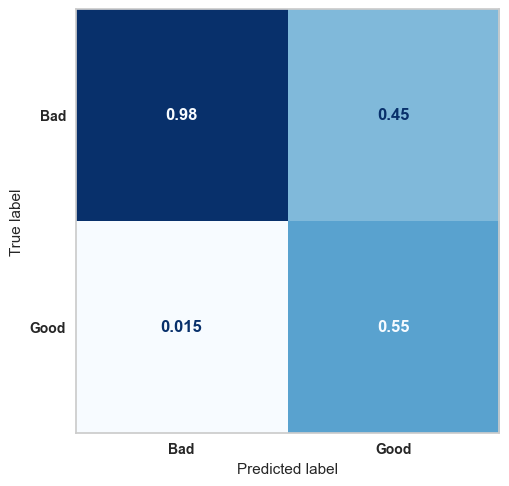

In [106]:
s_mix_bin =  setup(data = mixed_set_binary,test_data = data_fgfp_met_bin_2, target = 'Rating', session_id = 123,index = False)
rf_mix_bin = create_model("rf")
tuned_rf_mix_bin = tune_model(rf_mix_bin,n_iter=100)
test_mix_bin = get_config(variable="X_test")
test_y_mix_bin = get_config(variable="y_test")
predictions_mix_bin = predict_model(tuned_rf_mix_bin, data = test_mix_bin)


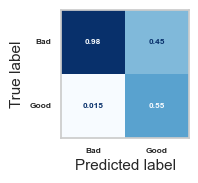

In [113]:
font = {'family' : 'arial','weight' : 'bold','size'   : 6}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay.from_predictions(test_y_mix_bin, predictions_mix_bin["prediction_label"],colorbar = False,cmap=plt.cm.Blues, labels = ["Bad","Good"],normalize = "pred")
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.rc('axes', titlesize=6)
plt.grid(b=None)
plt.gcf().set_size_inches(1.66, 1.66)
plt.savefig("multi_matrix_binary.png", dpi=300)

#### Multi-class

,Description,Value
0,Session id,123
1,Target,Rating
2,Target type,Multiclass
3,Target mapping,"Ambiguous: 0, Bad: 1, Good: 2"
4,Original data shape,"(1152, 5)"
5,Transformed data shape,"(1152, 5)"
6,Transformed train set shape,"(787, 5)"
7,Transformed test set shape,"(365, 5)"
8,Numeric features,4
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8608,0.9497,0.8608,0.8538,0.8508,0.7683,0.7742
1,0.7975,0.9162,0.7975,0.7862,0.7857,0.6539,0.6615
2,0.8987,0.9822,0.8987,0.8982,0.8961,0.8292,0.8323
3,0.8481,0.9411,0.8481,0.8279,0.8280,0.7381,0.7445
4,0.7468,0.8730,0.7468,0.7413,0.7328,0.5750,0.5872
5,0.7848,0.9110,0.7848,0.7643,0.7714,0.6327,0.6352
6,0.7342,0.8927,0.7342,0.7223,0.7207,0.5445,0.5530
7,0.6795,0.8709,0.6795,0.6685,0.6735,0.4660,0.4664
8,0.6667,0.8406,0.6667,0.6652,0.6615,0.4586,0.4624


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8861,0.9610,0.8861,0.8753,0.8732,0.8079,0.8129
1,0.7975,0.9448,0.7975,0.7791,0.7825,0.6522,0.6595
2,0.8861,0.9885,0.8861,0.8874,0.8831,0.8073,0.8122
3,0.8481,0.9396,0.8481,0.8327,0.8363,0.7421,0.7450
4,0.7468,0.8828,0.7468,0.7248,0.7222,0.5697,0.5853
5,0.7848,0.9353,0.7848,0.7609,0.7646,0.6321,0.6389
6,0.7342,0.9096,0.7342,0.7253,0.7182,0.5397,0.5530
7,0.7051,0.8803,0.7051,0.6958,0.7000,0.5088,0.5092
8,0.7051,0.8548,0.7051,0.6959,0.6964,0.5177,0.5217


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


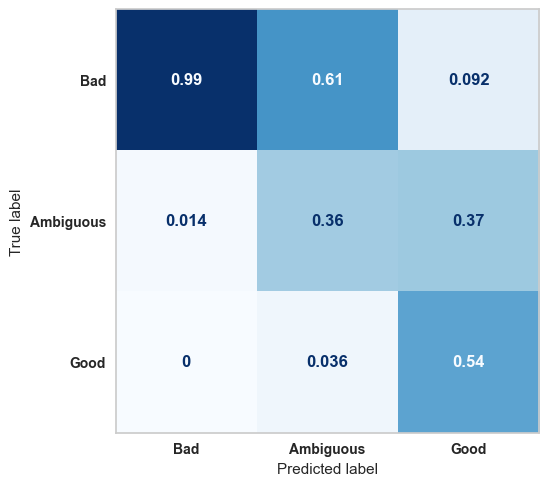

In [78]:
s_mix =  setup(data = mixed_set, test_data = data_fgfp_met, target = 'Rating', session_id = 123,index = False)
rf_mix = create_model("rf")
tuned_rf_mix = tune_model(rf_mix,n_iter=100)
test_mix = get_config(variable="X_test")
test_y_mix = get_config(variable="y_test")
predictions_mix = predict_model(tuned_rf_mix, data = test_mix)


Test on held out fgfp:

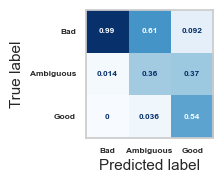

In [110]:
font = {'family' : 'arial','weight' : 'bold','size'   : 6}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay.from_predictions(test_y_mix, predictions_mix["prediction_label"],colorbar = False,cmap=plt.cm.Blues, labels = ["Bad","Ambiguous","Good"],normalize = "pred")
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.rc('axes', titlesize=6)
plt.grid(b=None)
plt.gcf().set_size_inches(1.66, 1.66)
plt.savefig("multi_matrix_mclasses.png", dpi=300)

In [101]:
confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
acc_test = accuracy_score(test_y_mix,predictions_mix["prediction_label"])
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / predictions_mix["prediction_label"].shape[0])
ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length
print(ci_lower, ci_upper)


0.5945205479452055